In [ ]:
!pip install minepy
!pip install scikit-optimize
!pip install barplots
!pip install cache_decorator
!pip install extra_keras_metrics
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader
!pip install keras_bed_sequence
!pip install boruta
!pip install seaborn

     |████████████████████████████████| 495 kB 33.1 MB/s 
  Created wheel for minepy: filename=minepy-1.2.5-cp37-cp37m-linux_x86_64.whl size=177542 sha256=5b624f9b9b3d70e2b4c395af777cc41f553871f7a59f36a3bbe71cd7066710ac
  Stored in directory: /root/.cache/pip/wheels/d1/ea/d7/fabbfa6e294adcbc43dabca0e0158dafdd36051246992c7311
Successfully built minepy
     |████████████████████████████████| 101 kB 9.2 MB/s 
  Created wheel for barplots: filename=barplots-1.1.11-py3-none-any.whl size=17877 sha256=a2d34a36c1a3e7e50abaabd1e8277a8b64ba8f19dc2565a61a029d60607333e2
  Stored in directory: /root/.cache/pip/wheels/2a/53/e4/1c71fe6cb782f2f43b23872deea5369ad81c11118361558728
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=8612a93609ee144980b0a327459714726ebe30d18759b80975e291309ba32a49
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=com

In [ ]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from cache_decorator import Cache
from tqdm.keras import TqdmCallback
from multiprocessing import cpu_count
from barplots import barplots
import matplotlib.pyplot as plt # A standard plotting library
import seaborn as sns

## Data retrieval and Pre-Processing.

In [ ]:
# Retrieving the data
X, y = load_epigenomes(
    cell_line = "H1",
    dataset = "fantom",
    region = "promoters",
    window_size = 256,
    root = "datasets", # Path where to download data,
    binarize = True,
    max_inactive_tpm_value=0.5,
    min_active_tpm_value=0.5
)

The rate between features and samples for promoters data is: 1722.0862068965516
Nan values report for promoters data:
In the document there are 19 NaN values out of 5793098 values.
The sample (row) with most values has 1 NaN values out of 58 values.
The feature (column) with most values has 1 NaN values out of 99881 values.
Class 0 ratio = 64690\99881 = 0.6476707281665182
Class 1 ratio = 35191\99881 = 0.35232927183348184


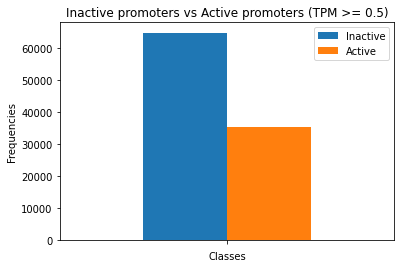

In [ ]:
#Check the rate between features and samples

print(
    f"The rate between features and samples for promoters data is: {X.shape[0]/X.shape[1]}"
)
print("="*80)

#Check if there are NaN values

print("\n".join((
    f"Nan values report for promoters data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=0).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))
print("="*80)
    
#Check if there is a strong imbalance between the classes
reset_y = y.reset_index()
classes_freq = reset_y["H1"].value_counts()

print("Class 0 ratio = " + str(classes_freq[0]) + "\\" + str(len(reset_y)) + " = " + str(classes_freq[0]/len(reset_y)))
print("Class 1 ratio = " + str(classes_freq[1]) + "\\" + str(len(reset_y)) + " = " + str(classes_freq[1]/len(reset_y)))

plotdata = pd.DataFrame({"Inactive":[classes_freq[0]], "Active": [classes_freq[1]]}, index=['']).plot(kind="bar")
plotdata.set_title("Inactive promoters vs Active promoters (TPM >= 0.5)")
plotdata.set_xlabel("Classes")
plotdata.set_ylabel("Frequencies")
plt.show()

In [ ]:
# Creating the imputer
imputer = KNNImputer()
# Creating the scaler
scaler = RobustScaler()

# Imputing and scaling the data
X = pd.DataFrame(
    scaler.fit_transform(
        imputer.fit_transform(X)
    ),
    index=X.index,
    columns=X.columns
)

print("\n".join((
    f"Nan values report for promoters data:",
    f"In the document there are {X.isna().values.sum()} NaN values out of {X.values.size} values.",
    f"The sample (row) with most values has {X.isna().sum(axis=0).max()} NaN values out of {X.shape[1]} values.",
    f"The feature (column) with most values has {X.isna().sum().max()} NaN values out of {X.shape[0]} values."
)))
print("="*80)

Nan values report for promoters data:
In the document there are 0 NaN values out of 5793098 values.
The sample (row) with most values has 0 NaN values out of 58 values.
The feature (column) with most values has 0 NaN values out of 99881 values.


### Most uncorrelated features with the output feature (Pearson, Spearman and MINE for non-linear correlations)


In [ ]:
from scipy.stats import pearsonr

p_value_threshold = 0.01
correlation_threshold = 0.05

n_top_scores = 5
scores = []
uncorrelated = set()
i = 0
for column in tqdm(X.columns, desc=f"Running Pearson test between features and output", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[column].values.ravel(), y.values.ravel())
    scores.append((column, correlation, p_value))
    if p_value > p_value_threshold:
        uncorrelated.add(column)
    i+=1

scores = sorted(scores, key=lambda x: (np.abs(x[1]), p_value), reverse=False)
n = [print(score) for score in scores[:n_top_scores]]

Running Pearson test between features and output:   0%|          | 0/58 [00:00<?, ?it/s]

('H3K79me2', -0.010563545348223872, 0.0008421701678713663)
('REST', 0.044133769896385705, 2.947803834403474e-44)
('H2AFZ', -0.05429470750359288, 4.323656618225851e-66)
('RFX5', 0.07365571077590355, 3.5520813885677516e-120)
('MAFK', 0.08498818635189728, 1.7711533917326733e-159)


In [ ]:
from scipy.stats import spearmanr

scores = []
for column in tqdm(X.columns, desc=f"Running Spearman test for promoters", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[column].values.ravel(), y.values.ravel())
    scores.append((column, correlation, p_value))
    if p_value > p_value_threshold:
        print(column, correlation)
        uncorrelated.add(column)

scores = sorted(scores, key=lambda x: (np.abs(x[1]), p_value), reverse=False)
n = [print(score) for score in scores[:n_top_scores]]

Running Spearman test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

('H2AFZ', -0.06669836399709583, 7.534839456169784e-99)
('RNF2', -0.06700248196655703, 9.756137954571015e-100)
('H3K79me2', -0.09243338474932511, 2.1632721677549202e-188)
('SUZ12', -0.14823787594553894, 0.0)
('MAFK', 0.16835234487518866, 0.0)


In [ ]:
from minepy import MINE

for column in tqdm(uncorrelated, desc=f"Running MINE test for promoters", dynamic_ncols=True, leave=False):
    mine = MINE()
    correlation, p_value = pearsonr(X[column].values.ravel(), y.values.ravel())
    mine.compute_score(X[column].values.ravel(), y.values.ravel())
    score = mine.mic()
    if score < correlation_threshold:
        print(column, score)
    else:
        uncorrelated.remove(column)

Running MINE test for promoters: 0it [00:00, ?it/s]

In [ ]:
#@title Top 5 most correlated pairs of features (linear correlation)


In [ ]:
from scipy.stats import pearsonr
from scipy.stats import entropy

p_value_threshold = 0.01
correlation_threshold = 0.95

extremely_correlated =  set()
n_top_scores = 5

scores = []
for i, column in tqdm(
    enumerate(X.columns),
    total=len(X.columns), desc=f"Running Pearson test for promoters", dynamic_ncols=True, leave=False):
    
    for feature in X.columns[i+1:]:
        correlation, p_value = pearsonr(X[column].values.ravel(), X[feature].values.ravel())
        correlation = correlation
        scores.append((correlation, column, feature))
        if p_value < p_value_threshold and correlation > correlation_threshold:
            if entropy(X[column]) > entropy(X[feature]):
                extremely_correlated.add(feature)
            else:
                extremely_correlated.add(column)

scores = sorted(scores, key=lambda x: np.abs(x[0]), reverse=True)
print("Most", str(n_top_scores), " correlated features with Pearson Correlation method:")
n = [print(score) for score in scores[:n_top_scores]]
print("Most", str(n_top_scores), " uncorrelated features with Pearson Correlation method:")
n = [print(score) for score in scores[-n_top_scores:]]

Running Pearson test for promoters:   0%|          | 0/58 [00:00<?, ?it/s]

Most 5  correlated features with Pearson Correlation method:
(0.9332611395103301, 'POLR2A', 'POLR2AphosphoS5')
(0.8965576515651565, 'H3K27ac', 'H3K9ac')
(0.8939524166139474, 'TAF1', 'POLR2A')
(0.8530017664983849, 'SUZ12', 'RNF2')
(0.8393124628935651, 'POLR2A', 'TAF7')
Most 5  uncorrelated features with Pearson Correlation method:
(-0.001538232331199475, 'GABPA', 'H3K27me3')
(-0.00140653848387121, 'ATF3', 'RNF2')
(0.000863143639540675, 'GTF2F1', 'RNF2')
(-0.0005509566839844097, 'H3K27me3', 'BACH1')
(0.0005310638815930989, 'H2AFZ', 'POLR2AphosphoS5')


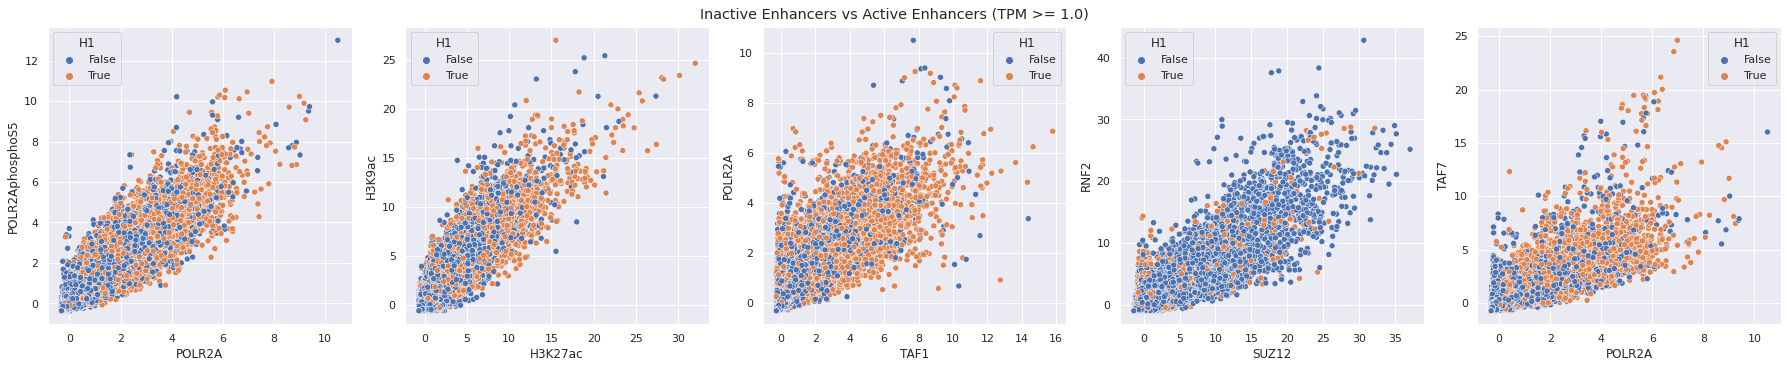

In [ ]:
top_scores = scores[:n_top_scores]
data = pd.concat([X, y], axis = 1)
sns.set(rc={'figure.figsize':(25,5)})

fig, axs = plt.subplots(ncols=n_top_scores)
i = 0
for i, score in enumerate(top_scores):
  sns.scatterplot(x = score[1], y = score[2], data = data, hue=y.columns[0],  ax=axs[i])

fig.suptitle('Inactive Promoters vs Active Promoters (TPM >= 0.5)', fontsize=20)
plt.tight_layout()

### Distributions visualization of the top five most different features

Top 5 different features from promoters.


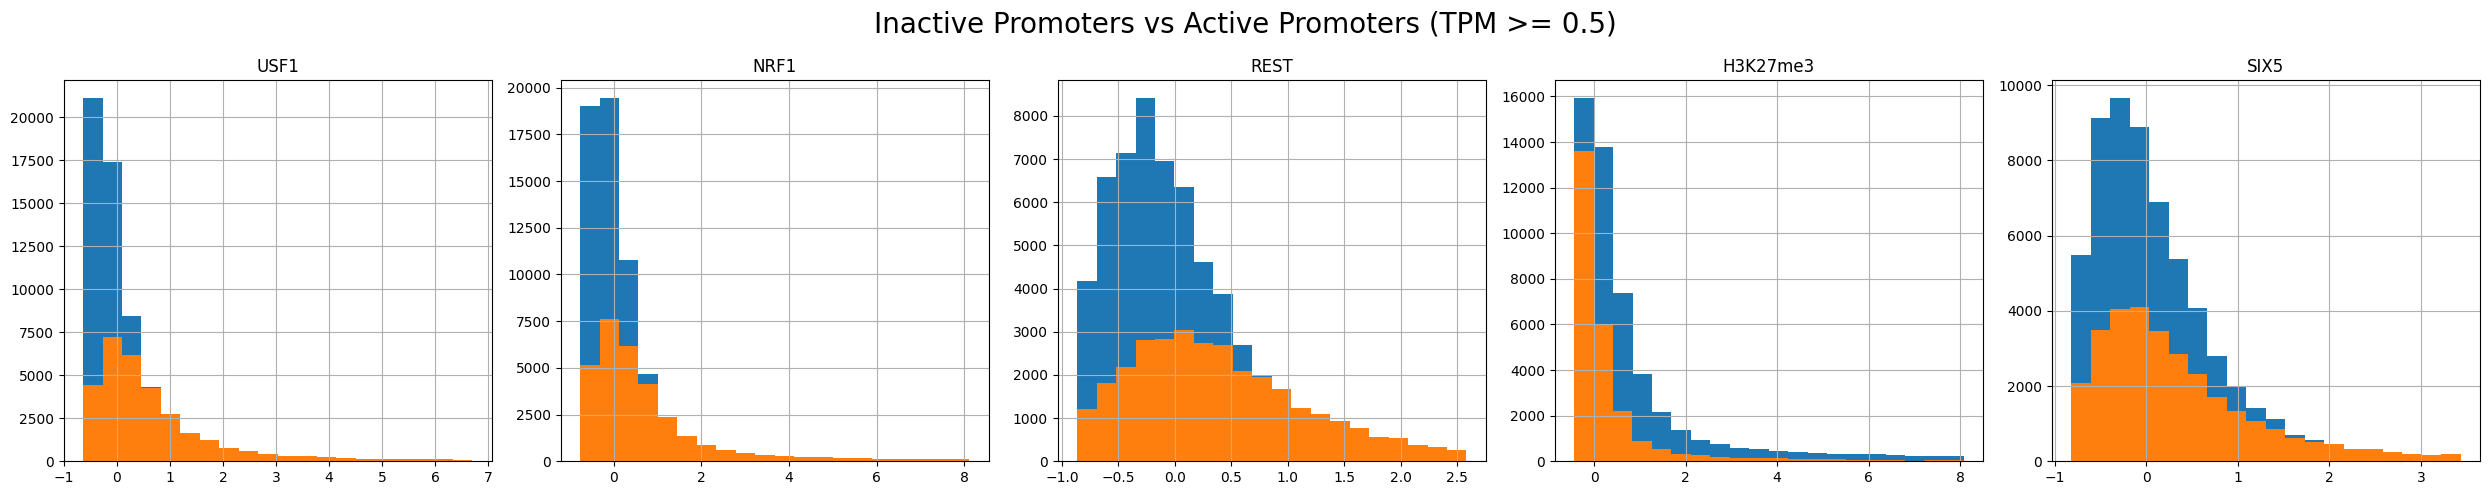

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

top_number = 5

dist = euclidean_distances(X.T)
most_distance_columns_indices = get_top_most_different(dist, top_number)
columns = X.columns[most_distance_columns_indices]
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
print(f"Top {top_number} different features from promoters.")
for column, axis in zip(columns, axes.flatten()):
    head, tail = X[column].quantile([0.05, 0.95]).values.ravel()

    mask = ((X[column] < tail) & (X[column] > head)).values

    cleared_X = X[column][mask]
    cleared_y = y.values.ravel()[mask]

    cleared_X[cleared_y==0].hist(ax=axis, bins=20)
    cleared_X[cleared_y==1].hist(ax=axis, bins=20)

    axis.set_title(column)
fig.suptitle('Inactive Promoters vs Active Promoters (TPM >= 0.5)', fontsize=20)
fig.tight_layout()
plt.show()

### Visualisation of the data by PCA decomposition

In [ ]:
from sklearn.decomposition import PCA

def pca(x:np.ndarray, n_components:int=2)->np.ndarray:
    return PCA(n_components=n_components, random_state=42).fit_transform(x)

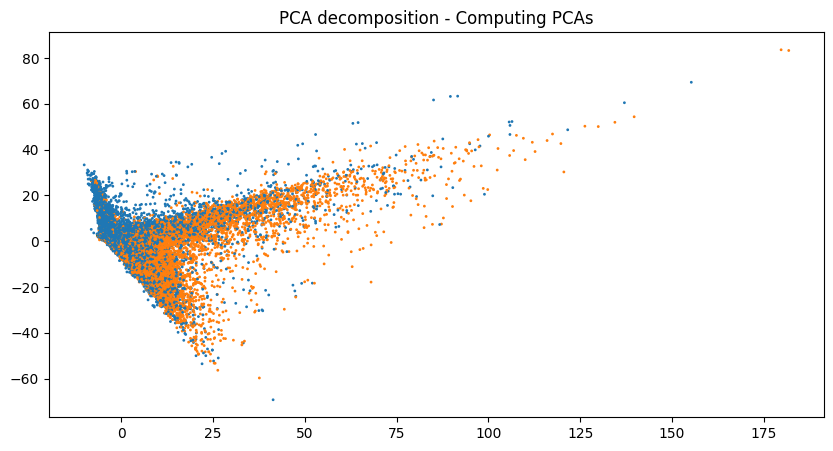

In [ ]:
from sklearn.decomposition import PCA
colors = np.array([
    "tab:blue",
    "tab:orange",
])

xseries = []
yseries = []
for example in pca(X):
    xseries.append(example[0])
    yseries.append(example[1])

tcolors = []
for color in colors[y.values.astype(int)]:
    tcolors.append(color[0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.scatter(xseries, yseries, s=1, c=tcolors)
axes.set_title(f"Inactive Promoters vs Active Promoters (TPM >= 0.5)")
plt.show()

## Feature selection
We will execute a feature selection step in each one of the holdouts, using the training data of the holdout. Otherwise, if we were to use all data, we would induce a possible positive bias in the model performance since we would use also data that we reserve to evaluate the models performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from multiprocessing import cpu_count

def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    max_iter: int = 200,
    verbose: int = 2
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5),
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=verbose,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

In [ ]:
#I've done this because I wanted to see if with all the dataset there was some features rejected
kept_features, discarded_features = execute_boruta_feature_selection(X, y.values.ravel(), 0)

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

In [ ]:
len(discarded_features) #No features have been discarded

0

## Model evaluation
In order to evaluate the model, we create a generator of **stratified** holdouts.

### Evaluation of the models predictions
In order to evaluate the models predictions, we consider the Accuracy, AUPRC and AUROC metrics:

In [ ]:
from typing import Dict
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score


def evaluate_model_prediction(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_true: np.ndarray,
        The ground truth labels.
    y_pred: np.ndarray,
        The predicted labels.
    
    Raises
    ---------------------
    ValueError,
        If the two given numpy arrays do not have the same shape.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    if y_true.shape != y_pred.shape:
        raise ValueError(
            "The two arrays do not have the same shape: {} != {}".format(
                y_true.shape, y_pred.shape
            )
        )
    float_metrics = average_precision_score, roc_auc_score
    int_metrics = (accuracy_score, )
    return {
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
            for metric in float_metrics
        },
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred).astype(int))
            for metric in int_metrics
        }
    }

In [ ]:
def evaluate_all_model_prediction(
    y_train_true: np.ndarray,
    y_train_pred: np.ndarray,
    y_test_true: np.ndarray,
    y_test_pred: np.ndarray,
    model_name: str,
    holdout_number: int,
    use_feature_selection: bool
) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_train_true: np.ndarray,
        Ground truth labels used during training.
    y_train_pred: np.ndarray,
        Training predictions
    y_test_true: np.ndarray,
        Ground truth labels used for test.
    y_test_pred: np.ndarray,
        Test predictions
    model_name: str,
        Name of the model used.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    common_informations = {
        "model_name": model_name,
        "holdout_number": holdout_number,
        "use_feature_selection": use_feature_selection
    }
    return [
        {
            **evaluate_model_prediction(y_train_true, y_train_pred),
            "run_type": "train",
            **common_informations,
        },
        {
            **evaluate_model_prediction(y_test_true, y_test_pred),
            "run_type": "test",
            **common_informations,
        },
    ]

### FFNN
We define a method to create and train a FFNN model:

### BAYESIAN OPTIMIZATION

In [ ]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

In [ ]:
#Definition of the dimensions in which we want to find the best hyper parameter's values for the task.
dim_learning_rate = Categorical(categories=[1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01],
                         name='learning_rate')
dim_regularization_factor = Categorical(categories=[1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01],
                         name='l2_regularization_factor')
dim_num_dense_layers = Integer(low=1, high=3, 
                               name='num_dense_layers')
dim_num_dense_nodes_3 = Categorical(categories=[128, 256, 512],  
                                    name='num_dense_nodes_3')
dim_num_dense_nodes_2 = Categorical(categories=[64, 128, 256],  
                                    name='num_dense_nodes_2')
dim_num_dense_nodes_1 = Categorical(categories=[16, 32, 64, 128], name=
                                    'num_dense_nodes_1')

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes_3,
              dim_num_dense_nodes_2,
              dim_num_dense_nodes_1,
              dim_regularization_factor]

In [ ]:
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Accuracy

from tensorflow.keras.optimizers import Adam

def create_model(X_train: np.ndarray, 
    learning_rate, 
    num_dense_layers,
    num_dense_nodes_3,             
    num_dense_nodes_2,
    num_dense_nodes_1,
    l2_regularization_factor):
    
    model = Sequential()

    model.add(InputLayer(input_shape=(X_train.shape[1])))
    
    #Composition of the 3th layer
    if num_dense_layers == 3:
        name = 'layer_dense_3'
        model.add(Dense(num_dense_nodes_3,
                        activation='relu',
                        kernel_regularizer=l2(l2_regularization_factor), #I put the same regularization_factor 
                                                                         #to all the dense layers;
                        name=name))
        
    #Composition of the 2th layer
    if num_dense_layers >= 2:
        name = 'layer_dense_2'
        model.add(Dense(num_dense_nodes_2,
                        activation='relu',
                        kernel_regularizer=l2(l2_regularization_factor),
                        name=name))
        
    #Composition of the 1th layer
    name = 'layer_dense_1'
    model.add(Dense(num_dense_nodes_1,
                activation='relu',
                kernel_regularizer=l2(l2_regularization_factor),
                name=name))


    # use softmax-activation for classification.
    model.add(Dense(1, activation='sigmoid'))
    
    # Use the Adam method for training the network.
    optimizer = Adam(lr=learning_rate)
    
    #compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(curve='ROC', name='AUROC'),  AUC(curve='PR', name='AUPRC')])
    return model

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 1
holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state = 42
)

for holdout_number, (train_indices, test_indices) in enumerate(holdouts_generator.split(X, y)):
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes_3, num_dense_nodes_2, num_dense_nodes_1, l2_regularization_factor):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    l2_regularization_factor:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes_3:', num_dense_nodes_3)
    print('num_dense_nodes_2:', num_dense_nodes_2)
    print('num_dense_nodes_1:', num_dense_nodes_1)
    print('l2_regularization_factor:', l2_regularization_factor)

    
    # Create the neural network with these hyper-parameters.
    model = create_model(X_train = X_train,
                         learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes_1=num_dense_nodes_1,
                         num_dense_nodes_2=num_dense_nodes_2,
                         num_dense_nodes_3=num_dense_nodes_3,
                         l2_regularization_factor=l2_regularization_factor)
    
   
    # Training phase
    history = model.fit(x= X_train,
                        y= y_train,
                        epochs=100,
                        batch_size=128,
                        validation_data=(X_test, y_test),
                        callbacks = [EarlyStopping(monitor = "val_loss", patience = 3)])

    # I use this metric because I want to put more importance to the positive examples
    val_loss = history.history['val_loss'][-1]

    # Print the result of the AUPRC metric over the validation set.
    print()
    print("val_loss: {0:.2%}".format(val_loss))
    print()

    del model
    K.clear_session()
    
    # Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # We need to negate the result so it can be minimized.
    return val_loss

In [ ]:
%%time

default_parameters = [0.1, 3, 256, 128, 64, 0.001]
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-01
num_dense_layers: 3
num_dense_nodes_3: 256
num_dense_nodes_2: 128
num_dense_nodes_1: 64
l2_regularization_factor: 0.001
Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 2.1715 - accuracy: 0.7512 - AUROC: 0.7848 - AUPRC: 0.6367 - val_loss: 0.6143 - val_accuracy: 0.7747 - val_AUROC: 0.8182 - val_AUPRC: 0.6885
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5635 - accuracy: 0.7668 - AUROC: 0.8156 - AUPRC: 0.6759 - val_loss: 0.5257 - val_accuracy: 0.7779 - val_AUROC: 0.8221 - val_AUPRC: 0.6727
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5288 - accuracy: 0.7651 - AUROC: 0.8115 - AUPRC: 0.6683 - val_loss: 0.5138 - val_accuracy: 0.7705 - val_AUROC: 0.8170 - val_AUPRC: 0.6563
Epoch 4/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5146 - accuracy: 0.7689 - AUROC: 0.8150 - AUPRC: 0.6674 - val_loss: 0.5115 - val_accuracy: 0.7732 - val_AUROC: 0.8159 - val_AUPRC: 0.67

Epoch 66/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4593 - accuracy: 0.7868 - AUROC: 0.8484 - AUPRC: 0.7361 - val_loss: 0.4661 - val_accuracy: 0.7836 - val_AUROC: 0.8446 - val_AUPRC: 0.7214
Epoch 67/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4591 - accuracy: 0.7869 - AUROC: 0.8485 - AUPRC: 0.7363 - val_loss: 0.4659 - val_accuracy: 0.7837 - val_AUROC: 0.8447 - val_AUPRC: 0.7216
Epoch 68/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4589 - accuracy: 0.7870 - AUROC: 0.8487 - AUPRC: 0.7366 - val_loss: 0.4657 - val_accuracy: 0.7839 - val_AUROC: 0.8448 - val_AUPRC: 0.7217
Epoch 69/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4588 - accuracy: 0.7870 - AUROC: 0.8488 - AUPRC: 0.7368 - val_loss: 0.4657 - val_accuracy: 0.7840 - val_AUROC: 0.8449 - val_AUPRC: 0.7216
Epoch 70/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4586 - accuracy: 0.7868 - AUROC: 0.8489 - AUPRC: 0.7370 - 

625/625 [==============================] - 1s 2ms/step - loss: 0.4583 - accuracy: 0.7907 - AUROC: 0.8542 - AUPRC: 0.7442 - val_loss: 0.4634 - val_accuracy: 0.7902 - val_AUROC: 0.8526 - val_AUPRC: 0.7323

val_loss: 46.34%

learning rate: 1.0e-02
num_dense_layers: 3
num_dense_nodes_3: 256
num_dense_nodes_2: 128
num_dense_nodes_1: 128
l2_regularization_factor: 0.0001
Epoch 1/100
625/625 [==============================] - 3s 4ms/step - loss: 0.5046 - accuracy: 0.7774 - AUROC: 0.8348 - AUPRC: 0.7041 - val_loss: 0.4748 - val_accuracy: 0.7854 - val_AUROC: 0.8471 - val_AUPRC: 0.7267
Epoch 2/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4776 - accuracy: 0.7810 - AUROC: 0.8424 - AUPRC: 0.7190 - val_loss: 0.4713 - val_accuracy: 0.7868 - val_AUROC: 0.8471 - val_AUPRC: 0.7213
Epoch 3/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4730 - accuracy: 0.7827 - AUROC: 0.8447 - AUPRC: 0.7232 - val_loss: 0.4691 - val_accuracy: 0.7874 - val_AUROC: 0.8475 - val_AU

625/625 [==============================] - 1s 2ms/step - loss: 0.6095 - accuracy: 0.7904 - AUROC: 0.8532 - AUPRC: 0.7452 - val_loss: 0.6147 - val_accuracy: 0.7894 - val_AUROC: 0.8494 - val_AUPRC: 0.7281
Epoch 40/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6076 - accuracy: 0.7905 - AUROC: 0.8534 - AUPRC: 0.7455 - val_loss: 0.6129 - val_accuracy: 0.7896 - val_AUROC: 0.8495 - val_AUPRC: 0.7281
Epoch 41/100
625/625 [==============================] - 2s 2ms/step - loss: 0.6057 - accuracy: 0.7903 - AUROC: 0.8536 - AUPRC: 0.7458 - val_loss: 0.6111 - val_accuracy: 0.7898 - val_AUROC: 0.8495 - val_AUPRC: 0.7283
Epoch 42/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6038 - accuracy: 0.7905 - AUROC: 0.8538 - AUPRC: 0.7464 - val_loss: 0.6094 - val_accuracy: 0.7893 - val_AUROC: 0.8497 - val_AUPRC: 0.7287
Epoch 43/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6021 - accuracy: 0.7907 - AUROC: 0.8540 - AUPRC: 0.7466 - val_loss: 0.6

Epoch 77/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5576 - accuracy: 0.7941 - AUROC: 0.8586 - AUPRC: 0.7557 - val_loss: 0.5660 - val_accuracy: 0.7909 - val_AUROC: 0.8526 - val_AUPRC: 0.7335
Epoch 78/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5568 - accuracy: 0.7944 - AUROC: 0.8586 - AUPRC: 0.7560 - val_loss: 0.5650 - val_accuracy: 0.7899 - val_AUROC: 0.8528 - val_AUPRC: 0.7337
Epoch 79/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5558 - accuracy: 0.7949 - AUROC: 0.8588 - AUPRC: 0.7561 - val_loss: 0.5643 - val_accuracy: 0.7908 - val_AUROC: 0.8527 - val_AUPRC: 0.7343
Epoch 80/100
625/625 [==============================] - 2s 2ms/step - loss: 0.5548 - accuracy: 0.7948 - AUROC: 0.8589 - AUPRC: 0.7565 - val_loss: 0.5633 - val_accuracy: 0.7904 - val_AUROC: 0.8528 - val_AUPRC: 0.7337
Epoch 81/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5540 - accuracy: 0.7943 - AUROC: 0.8589 - AUPRC: 0.7566 - 

625/625 [==============================] - 1s 2ms/step - loss: 0.6468 - accuracy: 0.7637 - AUROC: 0.8064 - AUPRC: 0.6787 - val_loss: 0.6487 - val_accuracy: 0.7644 - val_AUROC: 0.8049 - val_AUPRC: 0.6711
Epoch 38/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6450 - accuracy: 0.7643 - AUROC: 0.8076 - AUPRC: 0.6799 - val_loss: 0.6471 - val_accuracy: 0.7652 - val_AUROC: 0.8061 - val_AUPRC: 0.6723
Epoch 39/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6434 - accuracy: 0.7643 - AUROC: 0.8087 - AUPRC: 0.6808 - val_loss: 0.6456 - val_accuracy: 0.7659 - val_AUROC: 0.8071 - val_AUPRC: 0.6733
Epoch 40/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6418 - accuracy: 0.7649 - AUROC: 0.8097 - AUPRC: 0.6819 - val_loss: 0.6441 - val_accuracy: 0.7662 - val_AUROC: 0.8080 - val_AUPRC: 0.6742
Epoch 41/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6403 - accuracy: 0.7654 - AUROC: 0.8107 - AUPRC: 0.6830 - val_loss: 0.6

Epoch 75/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6131 - accuracy: 0.7728 - AUROC: 0.8269 - AUPRC: 0.7021 - val_loss: 0.6174 - val_accuracy: 0.7714 - val_AUROC: 0.8245 - val_AUPRC: 0.6915
Epoch 76/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6126 - accuracy: 0.7730 - AUROC: 0.8271 - AUPRC: 0.7025 - val_loss: 0.6170 - val_accuracy: 0.7715 - val_AUROC: 0.8247 - val_AUPRC: 0.6918
Epoch 77/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6122 - accuracy: 0.7732 - AUROC: 0.8274 - AUPRC: 0.7029 - val_loss: 0.6165 - val_accuracy: 0.7716 - val_AUROC: 0.8250 - val_AUPRC: 0.6921
Epoch 78/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6117 - accuracy: 0.7732 - AUROC: 0.8275 - AUPRC: 0.7031 - val_loss: 0.6161 - val_accuracy: 0.7719 - val_AUROC: 0.8253 - val_AUPRC: 0.6923
Epoch 79/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6112 - accuracy: 0.7736 - AUROC: 0.8278 - AUPRC: 0.7035 - 

625/625 [==============================] - 2s 3ms/step - loss: 1.2775 - accuracy: 0.7644 - AUROC: 0.8148 - AUPRC: 0.6852 - val_loss: 0.4991 - val_accuracy: 0.7739 - val_AUROC: 0.8334 - val_AUPRC: 0.6999
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4982 - accuracy: 0.7724 - AUROC: 0.8311 - AUPRC: 0.7023 - val_loss: 0.4927 - val_accuracy: 0.7768 - val_AUROC: 0.8357 - val_AUPRC: 0.7084
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4954 - accuracy: 0.7743 - AUROC: 0.8323 - AUPRC: 0.7026 - val_loss: 0.4933 - val_accuracy: 0.7753 - val_AUROC: 0.8350 - val_AUPRC: 0.7102
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4941 - accuracy: 0.7742 - AUROC: 0.8329 - AUPRC: 0.7063 - val_loss: 0.4919 - val_accuracy: 0.7765 - val_AUROC: 0.8344 - val_AUPRC: 0.7084
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4925 - accuracy: 0.7763 - AUROC: 0.8337 - AUPRC: 0.7055 - val_loss: 0.4952 

625/625 [==============================] - 1s 2ms/step - loss: 0.4448 - accuracy: 0.7934 - AUROC: 0.8580 - AUPRC: 0.7524 - val_loss: 0.4546 - val_accuracy: 0.7893 - val_AUROC: 0.8529 - val_AUPRC: 0.7339
Epoch 17/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4440 - accuracy: 0.7936 - AUROC: 0.8585 - AUPRC: 0.7542 - val_loss: 0.4516 - val_accuracy: 0.7910 - val_AUROC: 0.8536 - val_AUPRC: 0.7380
Epoch 18/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4438 - accuracy: 0.7941 - AUROC: 0.8587 - AUPRC: 0.7540 - val_loss: 0.4536 - val_accuracy: 0.7899 - val_AUROC: 0.8530 - val_AUPRC: 0.7372
Epoch 19/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4436 - accuracy: 0.7944 - AUROC: 0.8588 - AUPRC: 0.7547 - val_loss: 0.4530 - val_accuracy: 0.7904 - val_AUROC: 0.8530 - val_AUPRC: 0.7350
Epoch 20/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4432 - accuracy: 0.7929 - AUROC: 0.8590 - AUPRC: 0.7561 - val_loss: 0.4

625/625 [==============================] - 2s 3ms/step - loss: 0.4414 - accuracy: 0.7964 - AUROC: 0.8607 - AUPRC: 0.7578 - val_loss: 0.4496 - val_accuracy: 0.7916 - val_AUROC: 0.8555 - val_AUPRC: 0.7370
Epoch 8/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4388 - accuracy: 0.7968 - AUROC: 0.8625 - AUPRC: 0.7620 - val_loss: 0.4489 - val_accuracy: 0.7931 - val_AUROC: 0.8559 - val_AUPRC: 0.7402
Epoch 9/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4366 - accuracy: 0.7986 - AUROC: 0.8639 - AUPRC: 0.7652 - val_loss: 0.4505 - val_accuracy: 0.7910 - val_AUROC: 0.8554 - val_AUPRC: 0.7384
Epoch 10/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4338 - accuracy: 0.8004 - AUROC: 0.8658 - AUPRC: 0.7697 - val_loss: 0.4493 - val_accuracy: 0.7895 - val_AUROC: 0.8555 - val_AUPRC: 0.7385
Epoch 11/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4317 - accuracy: 0.8010 - AUROC: 0.8672 - AUPRC: 0.7733 - val_loss: 0.450

625/625 [==============================] - 1s 2ms/step - loss: 0.4630 - accuracy: 0.7828 - AUROC: 0.8454 - AUPRC: 0.7247 - val_loss: 0.4643 - val_accuracy: 0.7828 - val_AUROC: 0.8452 - val_AUPRC: 0.7199
Epoch 23/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4625 - accuracy: 0.7833 - AUROC: 0.8457 - AUPRC: 0.7253 - val_loss: 0.4639 - val_accuracy: 0.7823 - val_AUROC: 0.8455 - val_AUPRC: 0.7201
Epoch 24/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4620 - accuracy: 0.7833 - AUROC: 0.8461 - AUPRC: 0.7257 - val_loss: 0.4635 - val_accuracy: 0.7827 - val_AUROC: 0.8458 - val_AUPRC: 0.7206
Epoch 25/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4616 - accuracy: 0.7836 - AUROC: 0.8464 - AUPRC: 0.7265 - val_loss: 0.4630 - val_accuracy: 0.7831 - val_AUROC: 0.8461 - val_AUPRC: 0.7212
Epoch 26/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4612 - accuracy: 0.7836 - AUROC: 0.8466 - AUPRC: 0.7267 - val_loss: 0.4

Epoch 60/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4539 - accuracy: 0.7879 - AUROC: 0.8516 - AUPRC: 0.7366 - val_loss: 0.4563 - val_accuracy: 0.7863 - val_AUROC: 0.8505 - val_AUPRC: 0.7279
Epoch 61/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4538 - accuracy: 0.7878 - AUROC: 0.8516 - AUPRC: 0.7368 - val_loss: 0.4562 - val_accuracy: 0.7861 - val_AUROC: 0.8505 - val_AUPRC: 0.7281
Epoch 62/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4537 - accuracy: 0.7877 - AUROC: 0.8517 - AUPRC: 0.7369 - val_loss: 0.4561 - val_accuracy: 0.7860 - val_AUROC: 0.8506 - val_AUPRC: 0.7282
Epoch 63/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4536 - accuracy: 0.7878 - AUROC: 0.8518 - AUPRC: 0.7372 - val_loss: 0.4560 - val_accuracy: 0.7860 - val_AUROC: 0.8507 - val_AUPRC: 0.7283
Epoch 64/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4534 - accuracy: 0.7882 - AUROC: 0.8519 - AUPRC: 0.7374 - 

Epoch 45/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4421 - accuracy: 0.7948 - AUROC: 0.8600 - AUPRC: 0.7575 - val_loss: 0.4525 - val_accuracy: 0.7905 - val_AUROC: 0.8529 - val_AUPRC: 0.7344
Epoch 46/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4418 - accuracy: 0.7947 - AUROC: 0.8603 - AUPRC: 0.7580 - val_loss: 0.4526 - val_accuracy: 0.7903 - val_AUROC: 0.8529 - val_AUPRC: 0.7338
Epoch 47/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4415 - accuracy: 0.7951 - AUROC: 0.8605 - AUPRC: 0.7586 - val_loss: 0.4525 - val_accuracy: 0.7906 - val_AUROC: 0.8530 - val_AUPRC: 0.7345
Epoch 48/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4412 - accuracy: 0.7954 - AUROC: 0.8608 - AUPRC: 0.7588 - val_loss: 0.4519 - val_accuracy: 0.7904 - val_AUROC: 0.8534 - val_AUPRC: 0.7348
Epoch 49/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4409 - accuracy: 0.7952 - AUROC: 0.8609 - AUPRC: 0.7594 - 

Epoch 60/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5528 - accuracy: 0.7585 - AUROC: 0.7853 - AUPRC: 0.6607 - val_loss: 0.5512 - val_accuracy: 0.7582 - val_AUROC: 0.7880 - val_AUPRC: 0.6582
Epoch 61/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5511 - accuracy: 0.7590 - AUROC: 0.7865 - AUPRC: 0.6618 - val_loss: 0.5495 - val_accuracy: 0.7585 - val_AUROC: 0.7889 - val_AUPRC: 0.6591
Epoch 62/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5494 - accuracy: 0.7593 - AUROC: 0.7874 - AUPRC: 0.6627 - val_loss: 0.5479 - val_accuracy: 0.7588 - val_AUROC: 0.7899 - val_AUPRC: 0.6600
Epoch 63/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5477 - accuracy: 0.7596 - AUROC: 0.7884 - AUPRC: 0.6637 - val_loss: 0.5464 - val_accuracy: 0.7591 - val_AUROC: 0.7909 - val_AUPRC: 0.6610
Epoch 64/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5462 - accuracy: 0.7599 - AUROC: 0.7895 - AUPRC: 0.6647 - 

Epoch 98/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5114 - accuracy: 0.7672 - AUROC: 0.8112 - AUPRC: 0.6851 - val_loss: 0.5126 - val_accuracy: 0.7661 - val_AUROC: 0.8120 - val_AUPRC: 0.6795
Epoch 99/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5107 - accuracy: 0.7673 - AUROC: 0.8117 - AUPRC: 0.6855 - val_loss: 0.5120 - val_accuracy: 0.7661 - val_AUROC: 0.8123 - val_AUPRC: 0.6799
Epoch 100/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5101 - accuracy: 0.7675 - AUROC: 0.8120 - AUPRC: 0.6859 - val_loss: 0.5115 - val_accuracy: 0.7665 - val_AUROC: 0.8127 - val_AUPRC: 0.6803

val_loss: 51.15%

learning rate: 1.0e-06
num_dense_layers: 2
num_dense_nodes_3: 128
num_dense_nodes_2: 64
num_dense_nodes_1: 128
l2_regularization_factor: 0.1
Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 15.2424 - accuracy: 0.5620 - AUROC: 0.5653 - AUPRC: 0.4570 - val_loss: 15.1708 - val_accuracy: 0.5730 - val_AUROC: 0

Epoch 35/100
625/625 [==============================] - 1s 2ms/step - loss: 11.0125 - accuracy: 0.7263 - AUROC: 0.7476 - AUPRC: 0.6200 - val_loss: 10.9584 - val_accuracy: 0.7269 - val_AUROC: 0.7476 - val_AUPRC: 0.6146
Epoch 36/100
625/625 [==============================] - 1s 2ms/step - loss: 10.9025 - accuracy: 0.7271 - AUROC: 0.7496 - AUPRC: 0.6220 - val_loss: 10.8489 - val_accuracy: 0.7277 - val_AUROC: 0.7494 - val_AUPRC: 0.6165
Epoch 37/100
625/625 [==============================] - 1s 2ms/step - loss: 10.7934 - accuracy: 0.7278 - AUROC: 0.7514 - AUPRC: 0.6239 - val_loss: 10.7401 - val_accuracy: 0.7284 - val_AUROC: 0.7512 - val_AUPRC: 0.6182
Epoch 38/100
625/625 [==============================] - 1s 2ms/step - loss: 10.6850 - accuracy: 0.7292 - AUROC: 0.7530 - AUPRC: 0.6257 - val_loss: 10.6322 - val_accuracy: 0.7292 - val_AUROC: 0.7529 - val_AUPRC: 0.6199
Epoch 39/100
625/625 [==============================] - 1s 2ms/step - loss: 10.5774 - accuracy: 0.7301 - AUROC: 0.7546 - AUPRC: 

Epoch 73/100
625/625 [==============================] - 1s 2ms/step - loss: 7.3555 - accuracy: 0.7472 - AUROC: 0.7841 - AUPRC: 0.6596 - val_loss: 7.3155 - val_accuracy: 0.7433 - val_AUROC: 0.7837 - val_AUPRC: 0.6517
Epoch 74/100
625/625 [==============================] - 1s 2ms/step - loss: 7.2731 - accuracy: 0.7473 - AUROC: 0.7846 - AUPRC: 0.6602 - val_loss: 7.2334 - val_accuracy: 0.7434 - val_AUROC: 0.7844 - val_AUPRC: 0.6524
Epoch 75/100
625/625 [==============================] - 1s 2ms/step - loss: 7.1914 - accuracy: 0.7476 - AUROC: 0.7851 - AUPRC: 0.6607 - val_loss: 7.1520 - val_accuracy: 0.7438 - val_AUROC: 0.7847 - val_AUPRC: 0.6528
Epoch 76/100
625/625 [==============================] - 1s 2ms/step - loss: 7.1104 - accuracy: 0.7477 - AUROC: 0.7855 - AUPRC: 0.6612 - val_loss: 7.0714 - val_accuracy: 0.7443 - val_AUROC: 0.7852 - val_AUPRC: 0.6533
Epoch 77/100
625/625 [==============================] - 1s 2ms/step - loss: 7.0301 - accuracy: 0.7481 - AUROC: 0.7860 - AUPRC: 0.6617 - 

625/625 [==============================] - 3s 4ms/step - loss: 0.4413 - accuracy: 0.7960 - AUROC: 0.8607 - AUPRC: 0.7634 - val_loss: 0.4540 - val_accuracy: 0.7902 - val_AUROC: 0.8523 - val_AUPRC: 0.7338
Epoch 36/100
625/625 [==============================] - 2s 4ms/step - loss: 0.4409 - accuracy: 0.7967 - AUROC: 0.8611 - AUPRC: 0.7637 - val_loss: 0.4542 - val_accuracy: 0.7904 - val_AUROC: 0.8523 - val_AUPRC: 0.7334
Epoch 37/100
625/625 [==============================] - 2s 4ms/step - loss: 0.4405 - accuracy: 0.7973 - AUROC: 0.8613 - AUPRC: 0.7644 - val_loss: 0.4536 - val_accuracy: 0.7896 - val_AUROC: 0.8527 - val_AUPRC: 0.7341
Epoch 38/100
625/625 [==============================] - 2s 4ms/step - loss: 0.4400 - accuracy: 0.7973 - AUROC: 0.8617 - AUPRC: 0.7651 - val_loss: 0.4539 - val_accuracy: 0.7900 - val_AUROC: 0.8526 - val_AUPRC: 0.7335
Epoch 39/100
625/625 [==============================] - 2s 4ms/step - loss: 0.4395 - accuracy: 0.7974 - AUROC: 0.8620 - AUPRC: 0.7657 - val_loss: 0.4

625/625 [==============================] - 2s 3ms/step - loss: 0.4928 - accuracy: 0.7862 - AUROC: 0.8483 - AUPRC: 0.7369 - val_loss: 0.4975 - val_accuracy: 0.7859 - val_AUROC: 0.8459 - val_AUPRC: 0.7230
Epoch 21/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4920 - accuracy: 0.7866 - AUROC: 0.8488 - AUPRC: 0.7378 - val_loss: 0.4967 - val_accuracy: 0.7870 - val_AUROC: 0.8463 - val_AUPRC: 0.7241
Epoch 22/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4914 - accuracy: 0.7872 - AUROC: 0.8492 - AUPRC: 0.7387 - val_loss: 0.4962 - val_accuracy: 0.7867 - val_AUROC: 0.8465 - val_AUPRC: 0.7246
Epoch 23/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4907 - accuracy: 0.7871 - AUROC: 0.8496 - AUPRC: 0.7394 - val_loss: 0.4959 - val_accuracy: 0.7873 - val_AUROC: 0.8467 - val_AUPRC: 0.7245
Epoch 24/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4900 - accuracy: 0.7870 - AUROC: 0.8500 - AUPRC: 0.7402 - val_loss: 0.4

Epoch 58/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4765 - accuracy: 0.7931 - AUROC: 0.8585 - AUPRC: 0.7578 - val_loss: 0.4873 - val_accuracy: 0.7877 - val_AUROC: 0.8516 - val_AUPRC: 0.7325
Epoch 59/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4762 - accuracy: 0.7934 - AUROC: 0.8587 - AUPRC: 0.7581 - val_loss: 0.4872 - val_accuracy: 0.7882 - val_AUROC: 0.8516 - val_AUPRC: 0.7328
Epoch 60/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4759 - accuracy: 0.7933 - AUROC: 0.8589 - AUPRC: 0.7585 - val_loss: 0.4872 - val_accuracy: 0.7880 - val_AUROC: 0.8516 - val_AUPRC: 0.7333
Epoch 61/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4755 - accuracy: 0.7936 - AUROC: 0.8592 - AUPRC: 0.7592 - val_loss: 0.4873 - val_accuracy: 0.7881 - val_AUROC: 0.8516 - val_AUPRC: 0.7323
Epoch 62/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4753 - accuracy: 0.7936 - AUROC: 0.8593 - AUPRC: 0.7596 - 

625/625 [==============================] - 1s 2ms/step - loss: 0.5174 - accuracy: 0.7624 - AUROC: 0.8059 - AUPRC: 0.6782 - val_loss: 0.5183 - val_accuracy: 0.7629 - val_AUROC: 0.8065 - val_AUPRC: 0.6726
Epoch 41/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5160 - accuracy: 0.7631 - AUROC: 0.8068 - AUPRC: 0.6791 - val_loss: 0.5170 - val_accuracy: 0.7631 - val_AUROC: 0.8074 - val_AUPRC: 0.6734
Epoch 42/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5146 - accuracy: 0.7636 - AUROC: 0.8077 - AUPRC: 0.6801 - val_loss: 0.5157 - val_accuracy: 0.7637 - val_AUROC: 0.8083 - val_AUPRC: 0.6744
Epoch 43/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5134 - accuracy: 0.7641 - AUROC: 0.8086 - AUPRC: 0.6811 - val_loss: 0.5145 - val_accuracy: 0.7643 - val_AUROC: 0.8091 - val_AUPRC: 0.6753
Epoch 44/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5122 - accuracy: 0.7644 - AUROC: 0.8095 - AUPRC: 0.6820 - val_loss: 0.5

Epoch 78/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4890 - accuracy: 0.7721 - AUROC: 0.8260 - AUPRC: 0.7008 - val_loss: 0.4909 - val_accuracy: 0.7729 - val_AUROC: 0.8260 - val_AUPRC: 0.6941
Epoch 79/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4886 - accuracy: 0.7723 - AUROC: 0.8263 - AUPRC: 0.7012 - val_loss: 0.4906 - val_accuracy: 0.7731 - val_AUROC: 0.8263 - val_AUPRC: 0.6943
Epoch 80/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4882 - accuracy: 0.7726 - AUROC: 0.8266 - AUPRC: 0.7016 - val_loss: 0.4902 - val_accuracy: 0.7733 - val_AUROC: 0.8265 - val_AUPRC: 0.6946
Epoch 81/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4879 - accuracy: 0.7728 - AUROC: 0.8268 - AUPRC: 0.7020 - val_loss: 0.4899 - val_accuracy: 0.7736 - val_AUROC: 0.8268 - val_AUPRC: 0.6950
Epoch 82/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4875 - accuracy: 0.7731 - AUROC: 0.8271 - AUPRC: 0.7023 - 

Epoch 53/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4522 - accuracy: 0.7901 - AUROC: 0.8529 - AUPRC: 0.7435 - val_loss: 0.4577 - val_accuracy: 0.7896 - val_AUROC: 0.8494 - val_AUPRC: 0.7292
Epoch 54/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4519 - accuracy: 0.7901 - AUROC: 0.8530 - AUPRC: 0.7438 - val_loss: 0.4576 - val_accuracy: 0.7896 - val_AUROC: 0.8495 - val_AUPRC: 0.7294
Epoch 55/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4517 - accuracy: 0.7904 - AUROC: 0.8532 - AUPRC: 0.7441 - val_loss: 0.4575 - val_accuracy: 0.7894 - val_AUROC: 0.8496 - val_AUPRC: 0.7293
Epoch 56/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4515 - accuracy: 0.7901 - AUROC: 0.8534 - AUPRC: 0.7444 - val_loss: 0.4573 - val_accuracy: 0.7895 - val_AUROC: 0.8497 - val_AUPRC: 0.7299
Epoch 57/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4512 - accuracy: 0.7905 - AUROC: 0.8535 - AUPRC: 0.7449 - 

Epoch 91/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4450 - accuracy: 0.7930 - AUROC: 0.8580 - AUPRC: 0.7542 - val_loss: 0.4540 - val_accuracy: 0.7905 - val_AUROC: 0.8519 - val_AUPRC: 0.7344
Epoch 92/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4449 - accuracy: 0.7933 - AUROC: 0.8581 - AUPRC: 0.7544 - val_loss: 0.4539 - val_accuracy: 0.7906 - val_AUROC: 0.8520 - val_AUPRC: 0.7344
Epoch 93/100
625/625 [==============================] - 2s 2ms/step - loss: 0.4447 - accuracy: 0.7932 - AUROC: 0.8582 - AUPRC: 0.7548 - val_loss: 0.4539 - val_accuracy: 0.7900 - val_AUROC: 0.8520 - val_AUPRC: 0.7344
Epoch 94/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4446 - accuracy: 0.7934 - AUROC: 0.8583 - AUPRC: 0.7547 - val_loss: 0.4539 - val_accuracy: 0.7904 - val_AUROC: 0.8520 - val_AUPRC: 0.7347
Epoch 95/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4444 - accuracy: 0.7934 - AUROC: 0.8584 - AUPRC: 0.7552 - 

Epoch 66/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6198 - accuracy: 0.7781 - AUROC: 0.8324 - AUPRC: 0.7103 - val_loss: 0.6208 - val_accuracy: 0.7787 - val_AUROC: 0.8325 - val_AUPRC: 0.7058
Epoch 67/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6193 - accuracy: 0.7780 - AUROC: 0.8327 - AUPRC: 0.7106 - val_loss: 0.6203 - val_accuracy: 0.7790 - val_AUROC: 0.8328 - val_AUPRC: 0.7061
Epoch 68/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6188 - accuracy: 0.7782 - AUROC: 0.8329 - AUPRC: 0.7110 - val_loss: 0.6198 - val_accuracy: 0.7792 - val_AUROC: 0.8330 - val_AUPRC: 0.7064
Epoch 69/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6183 - accuracy: 0.7784 - AUROC: 0.8332 - AUPRC: 0.7113 - val_loss: 0.6193 - val_accuracy: 0.7794 - val_AUROC: 0.8332 - val_AUPRC: 0.7066
Epoch 70/100
625/625 [==============================] - 2s 2ms/step - loss: 0.6178 - accuracy: 0.7784 - AUROC: 0.8334 - AUPRC: 0.7116 - 

625/625 [==============================] - 1s 2ms/step - loss: 0.4735 - accuracy: 0.7812 - AUROC: 0.8435 - AUPRC: 0.7280 - val_loss: 0.4755 - val_accuracy: 0.7813 - val_AUROC: 0.8424 - val_AUPRC: 0.7200
Epoch 42/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4734 - accuracy: 0.7809 - AUROC: 0.8435 - AUPRC: 0.7282 - val_loss: 0.4738 - val_accuracy: 0.7828 - val_AUROC: 0.8434 - val_AUPRC: 0.7213
Epoch 43/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4732 - accuracy: 0.7816 - AUROC: 0.8436 - AUPRC: 0.7281 - val_loss: 0.4734 - val_accuracy: 0.7834 - val_AUROC: 0.8442 - val_AUPRC: 0.7227
Epoch 44/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4728 - accuracy: 0.7812 - AUROC: 0.8439 - AUPRC: 0.7294 - val_loss: 0.4737 - val_accuracy: 0.7828 - val_AUROC: 0.8436 - val_AUPRC: 0.7214
Epoch 45/100
625/625 [==============================] - 1s 2ms/step - loss: 0.4726 - accuracy: 0.7818 - AUROC: 0.8439 - AUPRC: 0.7295 - val_loss: 0.4

E:\anaconda\envs\cazzo_culo\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


learning rate: 1.0e-06
num_dense_layers: 2
num_dense_nodes_3: 512
num_dense_nodes_2: 256
num_dense_nodes_1: 32
l2_regularization_factor: 0.001
Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 0.8800 - accuracy: 0.5808 - AUROC: 0.4886 - AUPRC: 0.4071 - val_loss: 0.8540 - val_accuracy: 0.6195 - val_AUROC: 0.5545 - val_AUPRC: 0.4560
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.8369 - accuracy: 0.6425 - AUROC: 0.5941 - AUPRC: 0.4835 - val_loss: 0.8195 - val_accuracy: 0.6674 - val_AUROC: 0.6372 - val_AUPRC: 0.5173
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.8069 - accuracy: 0.6823 - AUROC: 0.6638 - AUPRC: 0.5371 - val_loss: 0.7945 - val_accuracy: 0.6958 - val_AUROC: 0.6899 - val_AUPRC: 0.5574
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.7845 - accuracy: 0.7076 - AUROC: 0.7075 - AUPRC: 0.5727 - val_loss: 0.7751 - val_accuracy: 0.7136 - val_AUROC: 0.7221 - val_AUPRC: 0.58

Epoch 76/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6167 - accuracy: 0.7791 - AUROC: 0.8351 - AUPRC: 0.7148 - val_loss: 0.6199 - val_accuracy: 0.7808 - val_AUROC: 0.8339 - val_AUPRC: 0.7030
Epoch 77/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6163 - accuracy: 0.7790 - AUROC: 0.8353 - AUPRC: 0.7152 - val_loss: 0.6195 - val_accuracy: 0.7805 - val_AUROC: 0.8341 - val_AUPRC: 0.7034
Epoch 78/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6158 - accuracy: 0.7792 - AUROC: 0.8355 - AUPRC: 0.7155 - val_loss: 0.6191 - val_accuracy: 0.7807 - val_AUROC: 0.8342 - val_AUPRC: 0.7036
Epoch 79/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6154 - accuracy: 0.7792 - AUROC: 0.8357 - AUPRC: 0.7158 - val_loss: 0.6187 - val_accuracy: 0.7810 - val_AUROC: 0.8345 - val_AUPRC: 0.7039
Epoch 80/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6150 - accuracy: 0.7794 - AUROC: 0.8359 - AUPRC: 0.7160 - 

625/625 [==============================] - 2s 3ms/step - loss: 0.5381 - accuracy: 0.7707 - AUROC: 0.8092 - AUPRC: 0.6866 - val_loss: 0.5369 - val_accuracy: 0.7701 - val_AUROC: 0.8105 - val_AUPRC: 0.6813
Epoch 13/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5343 - accuracy: 0.7717 - AUROC: 0.8116 - AUPRC: 0.6889 - val_loss: 0.5334 - val_accuracy: 0.7705 - val_AUROC: 0.8129 - val_AUPRC: 0.6835
Epoch 14/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5309 - accuracy: 0.7724 - AUROC: 0.8140 - AUPRC: 0.6911 - val_loss: 0.5303 - val_accuracy: 0.7713 - val_AUROC: 0.8149 - val_AUPRC: 0.6852
Epoch 15/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5279 - accuracy: 0.7730 - AUROC: 0.8160 - AUPRC: 0.6930 - val_loss: 0.5275 - val_accuracy: 0.7718 - val_AUROC: 0.8170 - val_AUPRC: 0.6869
Epoch 16/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5252 - accuracy: 0.7735 - AUROC: 0.8179 - AUPRC: 0.6950 - val_loss: 0.5

Epoch 50/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4946 - accuracy: 0.7828 - AUROC: 0.8398 - AUPRC: 0.7208 - val_loss: 0.4968 - val_accuracy: 0.7823 - val_AUROC: 0.8393 - val_AUPRC: 0.7122
Epoch 51/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4943 - accuracy: 0.7831 - AUROC: 0.8401 - AUPRC: 0.7212 - val_loss: 0.4965 - val_accuracy: 0.7824 - val_AUROC: 0.8394 - val_AUPRC: 0.7125
Epoch 52/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4940 - accuracy: 0.7833 - AUROC: 0.8403 - AUPRC: 0.7215 - val_loss: 0.4962 - val_accuracy: 0.7824 - val_AUROC: 0.8396 - val_AUPRC: 0.7128
Epoch 53/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4937 - accuracy: 0.7835 - AUROC: 0.8405 - AUPRC: 0.7218 - val_loss: 0.4959 - val_accuracy: 0.7824 - val_AUROC: 0.8398 - val_AUPRC: 0.7131
Epoch 54/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4934 - accuracy: 0.7835 - AUROC: 0.8408 - AUPRC: 0.7223 - 

Epoch 88/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4865 - accuracy: 0.7866 - AUROC: 0.8457 - AUPRC: 0.7307 - val_loss: 0.4898 - val_accuracy: 0.7868 - val_AUROC: 0.8440 - val_AUPRC: 0.7202
Epoch 89/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4863 - accuracy: 0.7866 - AUROC: 0.8458 - AUPRC: 0.7309 - val_loss: 0.4897 - val_accuracy: 0.7862 - val_AUROC: 0.8442 - val_AUPRC: 0.7205
Epoch 90/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4862 - accuracy: 0.7867 - AUROC: 0.8459 - AUPRC: 0.7310 - val_loss: 0.4895 - val_accuracy: 0.7868 - val_AUROC: 0.8442 - val_AUPRC: 0.7206
Epoch 91/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4860 - accuracy: 0.7868 - AUROC: 0.8460 - AUPRC: 0.7312 - val_loss: 0.4894 - val_accuracy: 0.7867 - val_AUROC: 0.8443 - val_AUPRC: 0.7207
Epoch 92/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4859 - accuracy: 0.7868 - AUROC: 0.8461 - AUPRC: 0.7314 - 

Epoch 63/100
625/625 [==============================] - 2s 4ms/step - loss: 0.4655 - accuracy: 0.7850 - AUROC: 0.8434 - AUPRC: 0.7283 - val_loss: 0.4692 - val_accuracy: 0.7861 - val_AUROC: 0.8414 - val_AUPRC: 0.7189
Epoch 64/100
625/625 [==============================] - 2s 4ms/step - loss: 0.4653 - accuracy: 0.7850 - AUROC: 0.8436 - AUPRC: 0.7286 - val_loss: 0.4690 - val_accuracy: 0.7866 - val_AUROC: 0.8415 - val_AUPRC: 0.7190
Epoch 65/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4651 - accuracy: 0.7852 - AUROC: 0.8437 - AUPRC: 0.7288 - val_loss: 0.4688 - val_accuracy: 0.7862 - val_AUROC: 0.8417 - val_AUPRC: 0.7193
Epoch 66/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4648 - accuracy: 0.7852 - AUROC: 0.8439 - AUPRC: 0.7291 - val_loss: 0.4686 - val_accuracy: 0.7862 - val_AUROC: 0.8418 - val_AUPRC: 0.7194
Epoch 67/100
625/625 [==============================] - 2s 3ms/step - loss: 0.4646 - accuracy: 0.7853 - AUROC: 0.8441 - AUPRC: 0.7295 - 


val_loss: 46.41%

learning rate: 1.0e-04
num_dense_layers: 1
num_dense_nodes_3: 128
num_dense_nodes_2: 128
num_dense_nodes_1: 64
l2_regularization_factor: 0.1
Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 4.9494 - accuracy: 0.6868 - AUROC: 0.6920 - AUPRC: 0.5682 - val_loss: 3.3868 - val_accuracy: 0.7474 - val_AUROC: 0.7736 - val_AUPRC: 0.6344
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 2.4408 - accuracy: 0.7592 - AUROC: 0.7982 - AUPRC: 0.6711 - val_loss: 1.7071 - val_accuracy: 0.7656 - val_AUROC: 0.8150 - val_AUPRC: 0.6792
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 1.2772 - accuracy: 0.7666 - AUROC: 0.8222 - AUPRC: 0.6954 - val_loss: 0.9555 - val_accuracy: 0.7677 - val_AUROC: 0.8272 - val_AUPRC: 0.6923
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.7805 - accuracy: 0.7689 - AUROC: 0.8304 - AUPRC: 0.7024 - val_loss: 0.6567 - val_accuracy: 0.7681 - val_AUROC: 0.8316 

In [ ]:
results = pd.DataFrame(sorted(zip(search_result.func_vals, search_result.x_iters)))
results.to_csv("best_models_promoters_0.5_ffnn.csv")

In [ ]:
from ast import literal_eval
results = pd.read_csv("best_models_promoters_0.5_ffnn.csv")
best_configuration = literal_eval(results["1"][0])

In [ ]:
results = pd.DataFrame(sorted(zip(search_result.func_vals, search_result.x_iters)))

In [ ]:
results

,0,1
0,0.450351,"[0.0001, 3, 512, 64, 128, 1e-06]"
1,0.451638,"[0.001, 2, 256, 64, 64, 1e-06]"
2,0.451730,"[1e-05, 3, 512, 64, 32, 1e-06]"
3,0.452042,"[0.001, 1, 128, 128, 16, 1e-06]"
4,0.452148,"[1e-05, 3, 512, 256, 16, 1e-06]"
5,0.452193,"[0.001, 3, 512, 256, 16, 1e-06]"
6,0.452586,"[0.0001, 1, 256, 64, 128, 1e-06]"
7,0.453220,"[0.0001, 2, 256, 64, 128, 1e-06]"
8,0.453426,"[0.001, 1, 128, 64, 32, 1e-06]"
9,0.453461,"[1e-05, 3, 128, 64, 16, 1e-06]"


In [ ]:
op_learning_rate = best_configuration[0]
op_num_dense_layers = best_configuration[1]
op_num_of_nodes_3 = best_configuration[2]
op_num_of_nodes_2 = best_configuration[3]
op_num_of_nodes_1 = best_configuration[4]
op_l2_regularization = best_configuration[5]

### Training of the FFNN 
with the best hyper parameter configuration obtained by the Bayesian Optimization procedure

In [ ]:
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from extra_keras_metrics import get_standard_binary_metrics
from tensorflow.keras.optimizers import Adam

def train_ffnn(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    holdout_number: int,
    use_feature_selection: bool
) :
    """Return performance of a FFNN.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    model = Sequential()
        
    #Composition of the 3th layer
    if op_num_dense_layers == 3:
        name = 'layer_dense_3'
        model.add(Dense(op_num_of_nodes_2,
                        activation='relu',
                        kernel_regularizer=l2(op_l2_regularization), #I put the same regularization_factor 
                                                                         #to all the dense layers;
                        name=name))
        
    #Composition of the 2th layer
    if op_num_dense_layers >= 2:
        name = 'layer_dense_2'
        model.add(Dense(op_num_of_nodes_2,
                        activation='relu',
                        kernel_regularizer=l2(op_l2_regularization),
                        name=name))
        
    #Composition of the 1th layer
    name = 'layer_dense_1'
    model.add(Dense(op_num_of_nodes_1,
                activation='relu',
                kernel_regularizer=l2(op_l2_regularization),
                name=name))


    # use softmax-activation for classification.
    model.add(Dense(1, activation='sigmoid'))
    
    
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=op_learning_rate),
        metrics=get_standard_binary_metrics()
    )
        
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=1000,
        batch_size=128,
        verbose=False,
        
        callbacks=[
            EarlyStopping(monitor = "val_loss", patience = 3),
            TqdmCallback(verbose=1)
        ]
    )
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "FFNN", holdout_number, use_feature_selection
    )

In [ ]:
# Create a list to store all the computed performance
all_performance = []
number_of_splits = 10
holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state = 42
)

# Start the main loop, iterating through the holdouts
for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(holdouts_generator.split(X, y)),
    total=number_of_splits,
    desc="Computing holdouts"
):
    # We do an internal loop for whether to use feature selection or not
    # Generally speaking, we always want to know if feature selection is doing something or not.
    for use_feature_selection in tqdm([True, False], desc="Running feature selection", leave=False):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
        # If the flag for feature selection is set, we compute the features
        # To keep and discard using Boruta.
        # We only do the feature selection once per holdout
        # because the data remains constant within the holdout.
        if use_feature_selection:
            kept_features, discarded_features = execute_boruta_feature_selection(
                X_train,
                y_train.values.ravel(),
                holdout_number,
                verbose = 1
            )
            # We filter the DataFrames columns using the features that
            # Boruta has decided we should keep
            X_train = X_train[kept_features]
            X_test = X_test[kept_features]
            
        # We compute the model performance
        performance = train_ffnn(
            X_train.values, X_test.values, y_train.values, y_test.values,
            holdout_number,
            use_feature_selection
        )
        # We chain the computed performance to the performance list
        all_performance += performance
# We convert the computed performance list into a DataFrame
all_performance = pd.DataFrame(all_performance)

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

Iteration: 	131 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	132 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	133 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	134 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	135 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	136 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	137 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	138 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	139 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	140 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	141 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	142 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	143 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	144 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	145 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	146 / 200
Confirmed: 	57
Ten

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	55
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	55
Tentative: 	3
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	55
Tentative: 	3
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	55
Tentative: 	3
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
I

Iteration: 	131 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	132 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	133 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	134 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	135 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	136 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	137 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	138 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	139 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	140 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	141 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	142 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	143 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	144 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	145 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	146 / 200
Confirmed: 	57
Ten

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

Iteration: 	131 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	132 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	133 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	134 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	135 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	136 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	137 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	138 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	139 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	140 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	141 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	142 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	143 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	144 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	145 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	146 / 200
Confirmed: 	57
Ten

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	56
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

Iteration: 	131 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	132 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	133 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	134 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	135 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	136 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	137 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	138 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	139 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	140 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	141 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	142 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	143 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	144 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	145 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	146 / 200
Confirmed: 	57
Ten

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

Iteration: 	131 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	132 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	133 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	134 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	135 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	136 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	137 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	138 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	139 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	140 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	141 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	142 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	143 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	144 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	145 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	146 / 200
Confirmed: 	57
Ten

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

Iteration: 	131 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	132 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	133 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	134 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	135 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	136 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	137 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	138 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	139 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	140 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	141 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	142 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	143 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	144 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	145 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	146 / 200
Confirmed: 	57
Ten

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration: 	1 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 200
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
I

Iteration: 	131 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	132 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	133 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	134 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	135 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	136 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	137 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	138 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	139 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	140 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	141 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	142 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	143 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	144 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	145 / 200
Confirmed: 	57
Tentative: 	1
Rejected: 	0
Iteration: 	146 / 200
Confirmed: 	57
Ten

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
all_performance.groupby(['run_type']).mean()

,Unnamed: 0,AUPRC,AUROC,Accuracy,holdout_number,use_feature_selection
run_type,,,,,,
test,20.0,0.732556,0.852197,0.788825,4.5,0.5
train,19.0,0.770130,0.866012,0.799926,4.5,0.5


### Results visualization
Now that we have run our experiment we can visualize its performance:

In [ ]:
all_performance.to_csv("all_performances_promoters_0.5_ffnn.csv")

In [ ]:
all_performance = pd.read_csv("all_performances_promoters_0.5_ffnn.csv")

In [ ]:
all_performance = all_performance.filter(items=['model_name', 'run_type', 'Accuracy', 'AUROC', 'AUPRC'])
all_performance.groupby(['run_type']).mean()

,Accuracy,AUROC,AUPRC
run_type,,,
test,0.788825,0.852197,0.732556
train,0.799926,0.866012,0.770130


In [ ]:
# Slightly adapting the dataframe in order to visualiza it better
all_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection == True else "No Feature Selection"
    for use_selection in all_performance["use_feature_selection"]
]
all_performance = all_performance.drop(columns=["holdout_number"])
all_performance = all_performance.drop(columns=["Unnamed: 0"])

Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

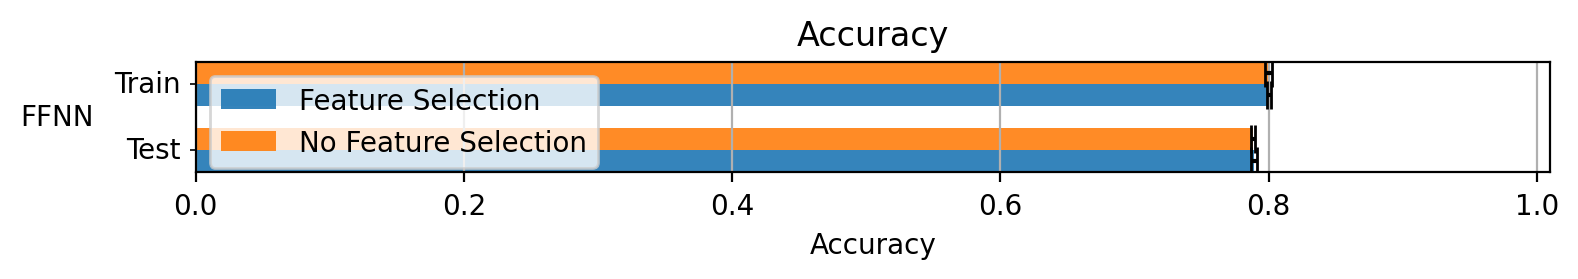

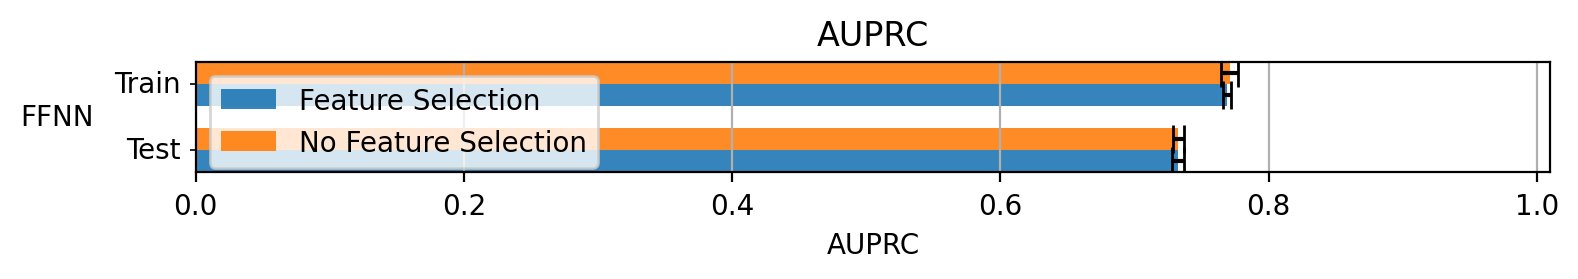

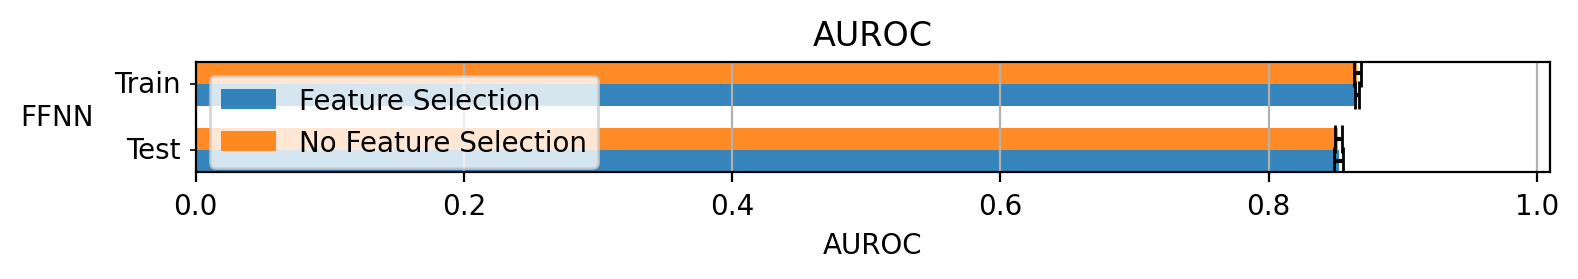

In [ ]:
barplots(
    all_performance,
    groupby=["model_name", "run_type", "use_feature_selection"],
    orientation="horizontal",
    height=8
)

plt.show()

In [ ]:
from scipy.stats import wilcoxon
for model in all_performance.model_name.unique():
    model_performance = all_performance[(all_performance.model_name == model) & (all_performance.run_type == "test")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "Accuracy"):
        print(
            model,
            metric,
            wilcoxon(performance_with_feature_selection[metric], performance_without_feature_selection[metric])
        )

FFNN AUPRC WilcoxonResult(statistic=26.0, pvalue=0.8784817434328712)
FFNN AUROC WilcoxonResult(statistic=24.0, pvalue=0.7212766990291557)
FFNN Accuracy WilcoxonResult(statistic=20.0, pvalue=0.4445867389117455)


<ipython-input-69-161b697bf90a>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  performance_with_feature_selection = model_performance[
<ipython-input-69-161b697bf90a>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  performance_without_feature_selection = model_performance[
